<a href="https://colab.research.google.com/github/hamed-karimi/hamed-karimi.github.io/blob/master/RL_simple_Hamed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import random
from collections import namedtuple, deque
from torch import optim
import matplotlib.pyplot as plt
import torch.nn.init as init

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Agent:
  def __init__(self, h, w):
    self.location = torch.from_numpy(np.asarray((np.random.randint(h), np.random.randint(w)))).unsqueeze(0)
    self.steps_done = 0
    self.episode_num = 1000
    self.episode_len = 500
    self.EPS_START = 0.9
    self.EPS_END = 0.05

  def get_epsilon(self):
    epsilon = self.EPS_START - (self.steps_done/(self.episode_num * self.episode_len)) * (self.EPS_START - self.EPS_END)
    return epsilon

  def get_location(self):
    # print('Agent location: ', self.location)
    return self.location

  def select_action(self, environment, policy_net): # Select an action based on value
    epsilon = self.get_epsilon()
    e = random.random()
    action_mask = environment.get_action_mask()
    if e > epsilon:
      with torch.no_grad():
        env_map = environment.env_map.clone()
        q = policy_net(env_map).squeeze() # This line which calls the policy_net.forward() function seems to cause the problem
        q[torch.logical_not(torch.from_numpy(action_mask).bool())[0]] = -3.40e+38
        # print('Q: ', q)

        action_id = q.argmax().unsqueeze(0)
    else:
      valid_actions = np.where(action_mask>0)[1]
      action_id = np.array(valid_actions[random.randint(0, valid_actions.shape[0]-1)])
      action_id = torch.from_numpy(action_id).unsqueeze(0)    
    self.steps_done += 1
    return action_id # to device
  
  def take_action(self, environment, action_id):
    # print('action id: ', action_id)
    selected_action = environment.allactions[action_id].squeeze() # to device
    # print('selected action: ', selected_action, 'agent location: ', self.location)
    self.location[0] += selected_action
    environment.update_agent_location_on_map(self)
    at_reward = environment.get_reward()
    at_cost = environment.get_cost(action_id)
    rho = at_reward - at_cost
    return rho.unsqueeze(0)

In [4]:
class Environment:
  def __init__(self, h, w, nObj, agent):
    self.channels = 2
    self.height = h
    self.width = w
    self.nObj = nObj
    self.agent_location = agent.get_location() #np.asarray((np.random.randint(self.height), np.random.randint(self.width)))
    self.env_map = torch.zeros((1, self.channels, self.height, self.width)) # the 1 is for the env_map can be matched with the dimesions of weights (8, 2, 4, 4)
    self.object_locations = torch.zeros((nObj, 2))
    self.init_object_locations()
    self.update_agent_location_on_map(agent)
    self.reward_of_object = [20]
    allactions_np = [np.array([0,0]),np.array([1,0]),np.array([-1,0]),np.array([0,1]),np.array([0,-1]),np.array([1,1]),np.array([-1,-1]),np.array([-1,1]),np.array([1,-1])]
    self.allactions = [torch.from_numpy(x).unsqueeze(0) for x in allactions_np]

  def init_object_locations(self): # Place objects on the map
    # self.env_map[0, self.agent_position[0], self.agent_position[1]] = 1
    for obj in range(self.nObj):
      do = 1
      while do:
        sample = np.array([np.random.randint(self.height), np.random.randint(self.width)])
        if not self.env_map[0, 1, sample[0], sample[1]]:
          self.object_locations[obj] = torch.from_numpy(sample)
          self.env_map[0, 1, sample[0], sample[1]] = 1
          do = 0
    
  def update_agent_location_on_map(self, agent): # This is called by the agent (take_action method) after the action is taken
    self.env_map[0, 0, self.agent_location[0, 0], self.agent_location[0, 1]] = 0
    self.agent_location = agent.get_location().clone()
    self.env_map[0, 0, self.agent_location[0, 0], self.agent_location[0, 1]] = 1

  def get_all_action(self):
    return self.allactions

  def get_action_mask(self):
    aa = np.ones((self.agent_location.size(0), len(self.allactions)))
    for i,location in enumerate(self.agent_location):
      if location[0] == 0:
            aa[i,2] = 0
            aa[i,6] = 0
            aa[i,7] = 0
      if location[0] == self.height-1:
            aa[i,1] = 0
            aa[i,5] = 0
            aa[i,8] = 0
      if location[1] == 0:
            aa[i,4] = 0
            aa[i,6] = 0
            aa[i,8] = 0
      if location[1] == self.width-1:
            aa[i,3] = 0
            aa[i,5] = 0
            aa[i,7] = 0
    return aa
  def get_reward(self):
    r = 0
    for obj in range(self.nObj):
      r += (torch.all(self.agent_location[0] == self.object_locations[obj]).int() * self.reward_of_object[obj])
    return r
  def get_cost(self, action_id):
    return torch.linalg.norm(self.allactions[action_id].squeeze().float())

In [5]:
class DQN(nn.Module):
  def __init__(self):
    super(DQN, self).__init__()
    self.conv1 = nn.Conv2d(2, 8, 4)
    self.fc1 = nn.Linear(8, 8)
    self.fc2 = nn.Linear(8, 9)
  def forward(self, env_map):
    y = F.relu(self.conv1(env_map))
    y = y.view(-1, self.num_flat_features(y))
    y = F.relu(self.fc1(y))
    y = self.fc2(y)
    return y
  def num_flat_features(self, x):                # This is a function we added for convenience to find out the number of features in a layer.
      size = x.size()[1:]                        # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

In [6]:
class Replay_Memory():
  def __init__(self, capacity=50000):
    self.memory = deque([], maxlen=capacity)
    self.Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
  def push(self, *args):
    self.memory.append(self.Transition(*args))
  def sample(self, size):
    return random.sample(self.memory, size)
  def __len__(self):
    return len(self.memory)


In [11]:
class Model_Optimizer:
  def __init__(self, policy_net, target_net, optimizer, batch_size, GAMMA):
    self.batch_size = batch_size
    self.memory = Replay_Memory()
    self.policy_net = policy_net
    self.target_net = target_net
    self.GAMMA = GAMMA
    self.optimizer = optimizer
  def save_experience(self, last_environment, action_id, reward, at_environment): # at_environment and last_environment are environment.env_map
    self.memory.push(last_environment, action_id, at_environment, reward)
  def update_target_net(self):
    self.target_net.load_state_dict(self.policy_net.state_dict())
  def optimize(self): 
    if self.memory.__len__() < self.batch_size:
      return float('nan')
    transition_sample = self.memory.sample(self.batch_size)
    batch = self.memory.Transition(*zip(*transition_sample))
    
    last_environment_batch = torch.cat([batch.state[i] for i in range(len(batch.state))])
    action_batch = torch.cat(batch.action)
    at_environment_batch = torch.cat([batch.next_state[i] for i in range(len(batch.next_state))])
    reward_batch = torch.cat(batch.reward)
    
    last_state_action_values = self.policy_net(last_environment_batch)
    at_state_action_values = self.target_net(at_environment_batch).max(1)[0].detach()
   
    action_values_of_selected_actions = last_state_action_values.gather(dim=1, index=action_batch.unsqueeze(1))
    expected_action_values_from_at = at_state_action_values * self.GAMMA + reward_batch
    
    criterion = nn.SmoothL1Loss()
    loss = criterion(action_values_of_selected_actions, expected_action_values_from_at.unsqueeze(1))
    # Optimize the model
    self.optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        #print('test')
        param.grad.data.clamp_(-1, 1)
    self.optimizer.step()
    return loss

In [10]:
def weights_init_orthogonal(m):
  classname = m.__class__.__name__
  #print(classname)
  if classname.find('Conv') != -1:
    init.orthogonal_(m.weight.data, gain=1)
  elif classname.find('Linear') != -1:
    init.orthogonal_(m.weight.data, gain=1)
  elif classname.find('BatchNorm') != -1:
    init.normal(m.weight.data, 1.0, 0.02)
    init.constant(m.bias.data, 0.0) 

In [14]:
agent = Agent(4, 4)
env = Environment(4, 4, 1, agent)
policy_net = DQN()
policy_net.apply(weights_init_orthogonal)
target_net = DQN()
target_net.load_state_dict(policy_net.state_dict())
TARGET_UPDATE = 100
BATCH_SIZE = 256
total_loss = []
total_reward = []
model_optimizer = Model_Optimizer(policy_net, target_net, \
                                  optimizer=optim.RMSprop(policy_net.parameters()), batch_size=BATCH_SIZE, GAMMA=0.99)
for episode in range(agent.episode_num):
  cum_loss = 0
  cum_reward = 0
  for action in range(agent.episode_len):
    last_environment = env.env_map.clone()
    action_id = agent.select_action(env, model_optimizer.policy_net)
    # print('action id here: ', action_id)
    rho = agent.take_action(env, action_id)
    model_optimizer.save_experience(last_environment, action_id, rho, env.env_map.clone())
    cum_reward += rho
    if action > 10:
      cum_loss += model_optimizer.optimize()

  total_reward.append(cum_reward/agent.episode_num)
  total_loss.append(cum_loss/agent.episode_num)

  if episode % 10 == 0:
    print(cum_reward/agent.episode_num,' ')
    print(cum_loss/agent.episode_num,'\n')
  if (episode+1) % TARGET_UPDATE == 0:
    model_optimizer.update_target_net()
    print('TARGET NET UPDATED')

tensor([-0.2146])  
tensor(nan, grad_fn=<DivBackward0>) 

tensor([0.0451])  
tensor(0.0021, grad_fn=<DivBackward0>) 

tensor([0.6133])  
tensor(0.0018, grad_fn=<DivBackward0>) 

tensor([-0.0659])  
tensor(0.0018, grad_fn=<DivBackward0>) 

tensor([0.3994])  
tensor(0.0016, grad_fn=<DivBackward0>) 

tensor([0.3852])  
tensor(0.0016, grad_fn=<DivBackward0>) 

tensor([0.5839])  
tensor(0.0017, grad_fn=<DivBackward0>) 

tensor([0.7442])  
tensor(0.0015, grad_fn=<DivBackward0>) 

tensor([0.3147])  
tensor(0.0014, grad_fn=<DivBackward0>) 

tensor([0.4821])  
tensor(0.0013, grad_fn=<DivBackward0>) 

TARGET NET UPDATED
tensor([0.8992])  
tensor(0.4502, grad_fn=<DivBackward0>) 

tensor([1.1577])  
tensor(0.1761, grad_fn=<DivBackward0>) 

tensor([1.7485])  
tensor(0.1658, grad_fn=<DivBackward0>) 

tensor([1.0677])  
tensor(0.1522, grad_fn=<DivBackward0>) 

tensor([1.3792])  
tensor(0.1402, grad_fn=<DivBackward0>) 

tensor([2.0502])  
tensor(0.0695, grad_fn=<DivBackward0>) 

tensor([1.7432])  
ten

/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Text(0.5, 1.0, 'Reward')

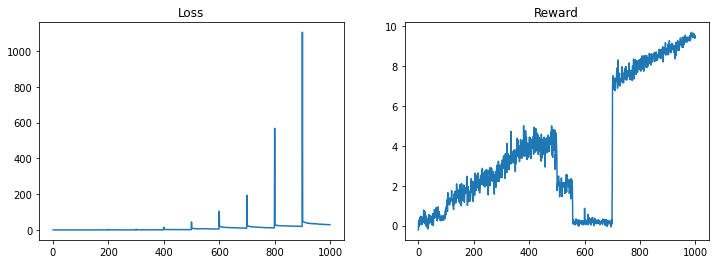

In [15]:
total_loss_nograd = [tl.detach() for tl in total_loss]
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(total_loss_nograd)
plt.title('Loss')
plt.subplot(122)
plt.plot(total_reward)
plt.title('Reward')

In [16]:
total_loss_nograd[-1]

tensor(29.2846)

In [ ]:
for action in range(10):
    last_environment = env.env_map.clone()
    action_id = agent.select_action(env, policy_net)
    print('action id here: ', action_id)
    rho = agent.take_action(env, action_id)
    print('reward: ', rho)
    # model_optimizer.save_experience(last_environment, action_id, rho, env.env_map)

action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])
action id here:  tensor([0])
reward:  tensor([0.])


In [ ]:
# for name, param in target_net.named_parameters():
  # print(name, param)
print(total_reward[400:600])

[tensor([0.2223]), tensor([0.3231]), tensor([-0.0843]), tensor([0.2333]), tensor([0.5822]), tensor([-0.0974]), tensor([0.0329]), tensor([0.3329]), tensor([0.5749]), tensor([0.3354]), tensor([0.6963]), tensor([0.4295]), tensor([0.3649]), tensor([0.2431]), tensor([0.4726]), tensor([0.1629]), tensor([0.3178]), tensor([0.3855]), tensor([0.8084]), tensor([-0.0464]), tensor([0.0736]), tensor([0.5187]), tensor([0.3266]), tensor([0.5044]), tensor([0.5860]), tensor([0.6388]), tensor([0.3592]), tensor([0.2441]), tensor([0.7500]), tensor([0.9670]), tensor([0.1421]), tensor([-0.0031]), tensor([0.3086]), tensor([1.6663]), tensor([0.0936]), tensor([0.2251]), tensor([0.4435]), tensor([0.2062]), tensor([0.1350]), tensor([0.3958]), tensor([0.4235]), tensor([0.5068]), tensor([0.3683]), tensor([0.1345]), tensor([0.6156]), tensor([0.8223]), tensor([0.5481]), tensor([0.8202]), tensor([0.5928]), tensor([0.1355]), tensor([0.3846]), tensor([0.2975]), tensor([0.2849]), tensor([0.0651]), tensor([0.2093]), tenso

In [ ]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
memory = Replay_Memory()
for i in range(20):
  memory.push('state%d' %(i), 'action%d' %(i), 'next_state%d' %(i), 'reward%d' %(i))
transitions = memory.sample(5)
print(*zip(*transitions))
print(memory.Transition(*zip(*transitions)))
batch = memory.Transition(*zip(*transitions))
aa = [ss for ss in batch.state]
print(aa)

In [ ]:
conv2d = nn.Conv2d(2, 8, 4)
fc1 = nn.Linear(8, 8)
fc2 = nn.Linear(8, 9)
y = F.relu(conv2d(env.env_map))
print(y.size())
y = y.view(-1)
y = F.relu(fc1(y))
print(y.size())
y = fc2(y)
print(y.size())

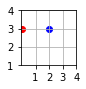

In [ ]:
fig, ax = plt.subplots(figsize=(1, 1))
ax.scatter(agent.location[0, 0].float(), agent.location[0, 1].float(), c='b')
ax.scatter(env.object_locations[0, 0].int(), env.object_locations[0, 1].int(), c='r')
ax.set_xticks([1, 2, 3, 4])
ax.set_yticks([1, 2, 3, 4])
ax.grid(True)
# ax.clear()

In [ ]:
agent.location[0, 0].int()

tensor(2, dtype=torch.int32)

In [ ]:
#@title
aid = np.zeros(len(mask[0]))
# print(np.int(sum(mask[0])))
aa = np.zeros(np.int(sum(mask[0])))

aa[random.randint(0,sum(mask[0])-1)] = 1
print(aa)
print(np.where(mask[0]>0))
aid[np.where(mask[0]>0)] = aa
actionid = np.where(aid>0)
actionid = torch.from_numpy(actionid[0])

In [ ]:
#@title
print(mask)
actions = env.get_all_action()
valid_actions = np.where(mask>0)[1]
action_id = np.array(valid_actions[random.randint(0, valid_actions.shape[0]-1)])
action_id = torch.from_numpy(action_id).unsqueeze(0)
print(actions)
print(action_id)
print(actions[action_id])